# 3D reconstruction with MPSE

This jupyter notebook is for a minimal demonstration of the 3D reconstruction algorithm we proposed. Being minimal, not all features are included to keep everything working in Binder and keep the loading time minimal. For example, we used a simpler implementation of raytracing algorithm to work on CPU and there is no support for GPU in this notebook. For full access to code, download the repository and run the example notebooks from there to see all the features. 

# Import dependencies

This the following cell, we import all the python libraries required to run this notebook. 

In [1]:
import plotly.express as px
import numpy as np
from tqdm import tqdm
import pandas as pd

from scipy.spatial import distance_matrix
from sklearn.manifold import MDS

from matplotlib import pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import os
from MPSE.MPSE import mview
from utils import *

# import pyvista as pv

%matplotlib inline

2022-11-10 13:21:12.056387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 13:21:12.167602: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 13:21:12.608745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-10 13:21:12.608787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# Accessing the data
As ShapeNet is a large dataset, we use a subset of it called ModelNet10. Following cell loads the 3D mesh objects, and samples `n_points` from that mesh.

/home/insane/.keras/datasets/ModelNet10/chair/train/chair_0001.off


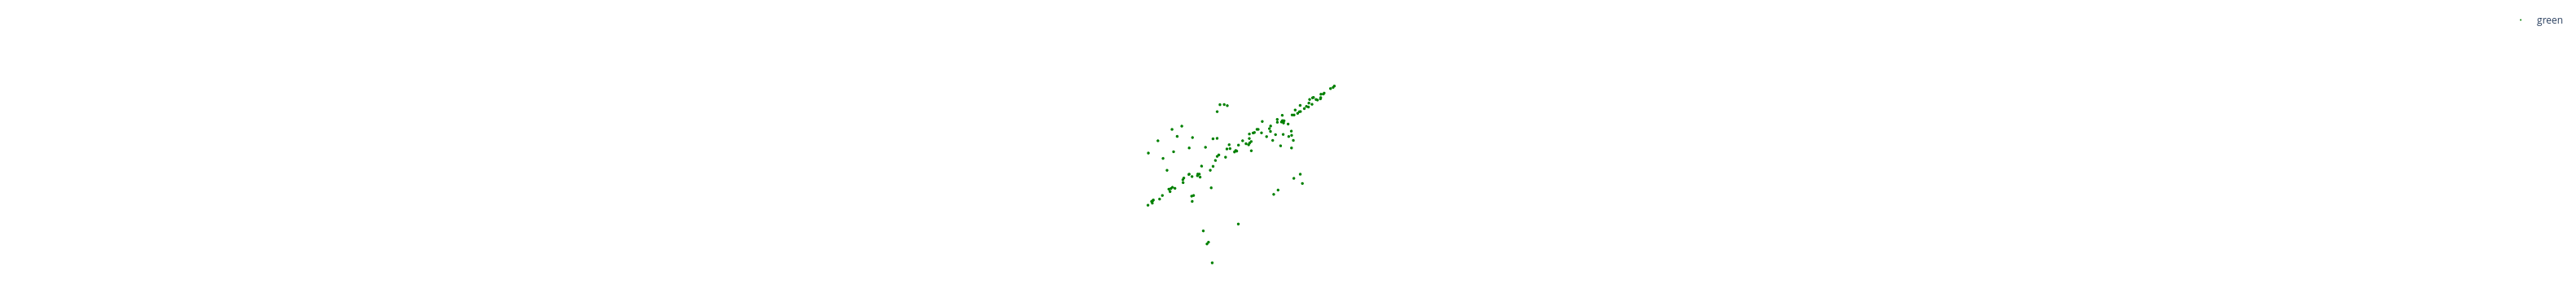

In [3]:
dataset = "ModelNet10:chair:0001"
points = load_dataset(dataset, n_points=128)
plot_3D_paper([points]).show()

# Create Viewpoints

We need to create viewpoints from the ground truth point cloud. We can do this in two ways. For testing the scalability, we use viewpoint generation pipeline which create `n_viewpoints` viewpoints where each point is visible at `n_points_visible` viewpoints. Alternatively using `get_raytracing(points, n_viewpoints)`, we can apply raytracing and get the viewpoints from that algorithm.

In this example, we create 5 viewpoints where each point is visible from 3 viewpoints.

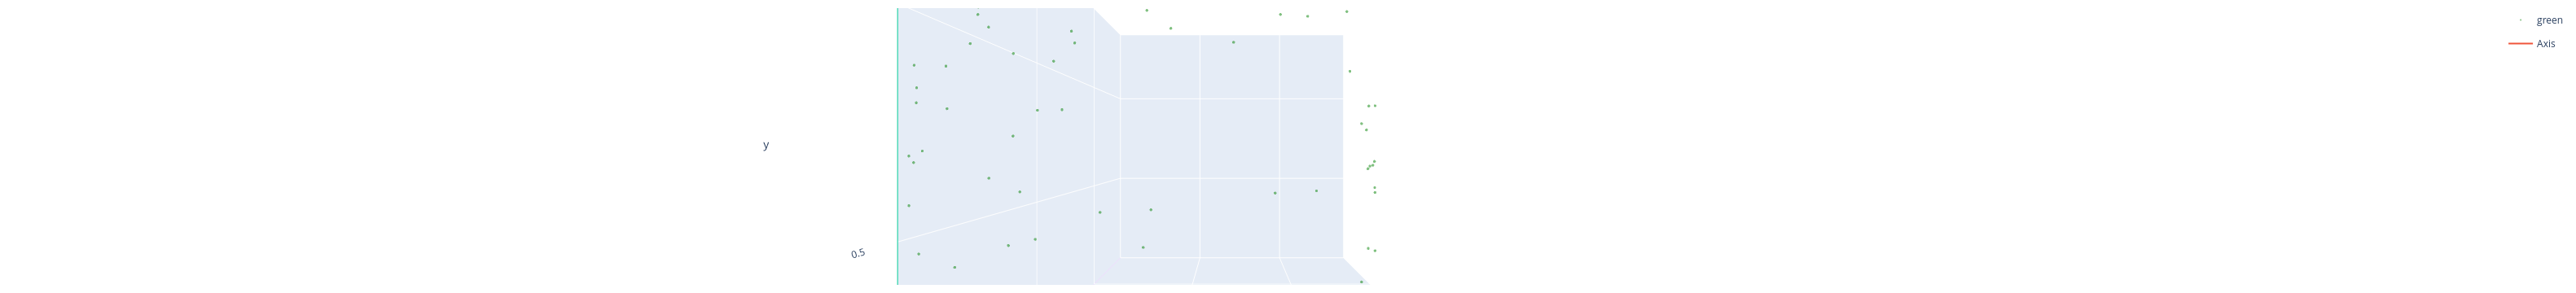

In [4]:
labeled_perspectives = get_all_viewpoints(points, 5, 3)
# labeled_perspectives = get_raytracing(points, 5)

plot_3D([add_col(remove_ids(labeled_perspectives[0]))]).show()

# Calculating the Distance Matrix

Now we calculate the distance matrix from those viewpoints as the input in MPSE. We also calculate the `weight_mats` matrix where $weight_mats_{i,j}$ is 0 if the point i or point j is not visible for that perspective, 1 otherwise.

The bar plot shows the percentage of points visible in each viewpoints.

5it [00:00, 69.72it/s]


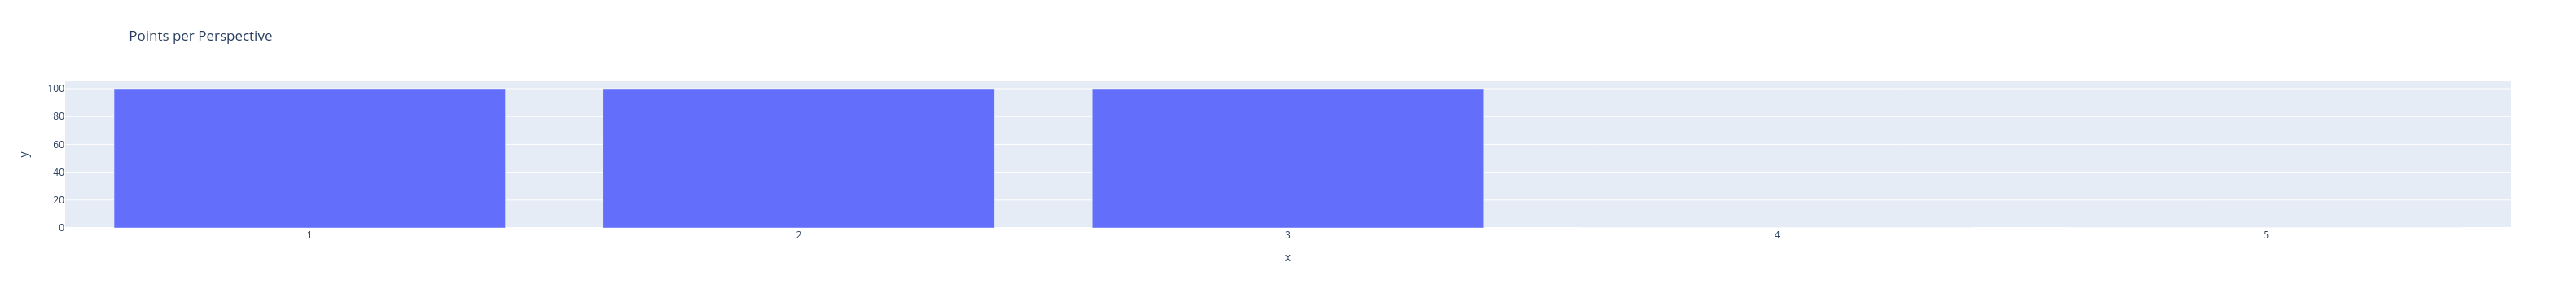

In [5]:
dist_mats, weights_mats = get_dist_weights(labeled_perspectives, len(points), ndim=2)

points_per_persp = np.array(show_points_least_persp(weights_mats))
points_per_persp = points_per_persp/points_per_persp.max() * 100

fig = px.bar(points_per_persp, x=range(1, len(points_per_persp)+1), y=points_per_persp, title="Points per Perspective")
fig.show()

# Baseline Metric

Now we estimate the point cloud with baseline metric. We also calculate EMD and Chamfer distance of the MDS-based 3D reconstruction and ground truth.

4 Point Alignment: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16108.15it/s]

Chamfer: 16.395061889866405
EMD: 12.158383529186015


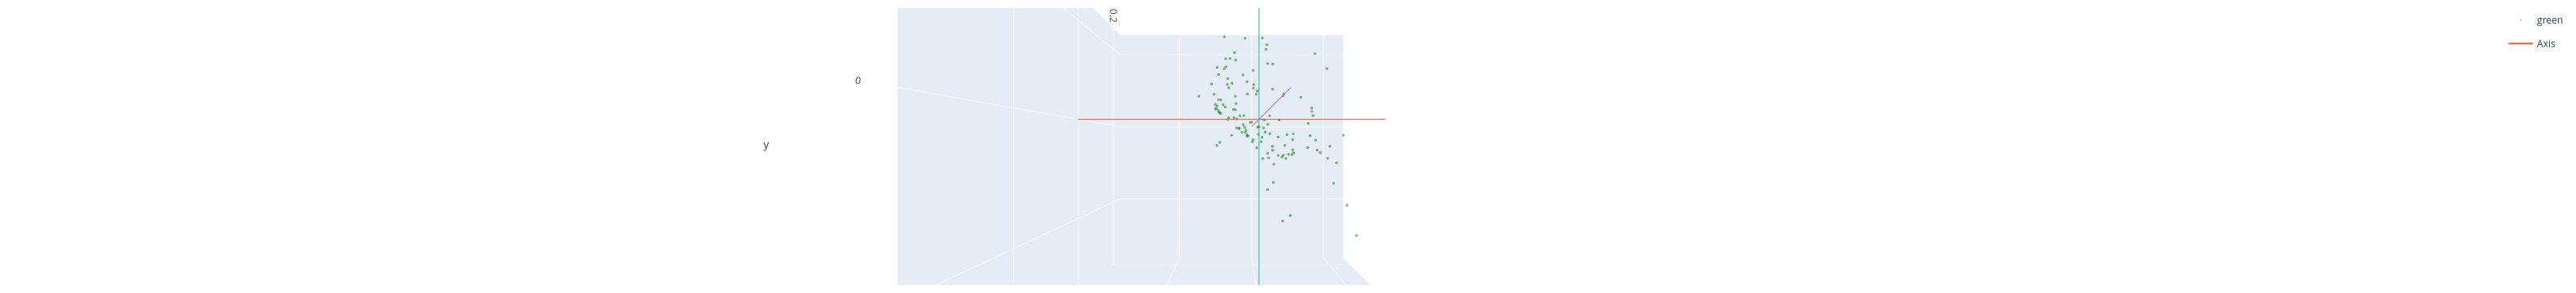

In [6]:
baseline = get_baseline_metrics(points, dist_mats)
print('Chamfer:', baseline['chamfer'])
print('EMD:', baseline['EMD'])

plot_3D([baseline['embeddings']]).show()

# Our methodology

In the following cell, we estimate the embedding of point cloud with our approach. The name of the parameters are self explanatory. 

All the computation details are printed live when running the algorithm. Finally we get the plots for normals of the embedding for each perspective. We also show the hidden points reconstruction in black dots. Finally we show a 3D plot for the final embedding.

mview.MPSE():
  data details:
    number of perspectives : 5
    number of samples : 128
  visualization details:
    embedding dimension : 3
    image dimension : 2
    visualization type : mds
  setup visualization instance for perspective 1 :
    mview.MDS():
      data details:
        number of samples : 128
        weighted : True
      embedding details:
        embedding dimension : 2
    initial embedding : random
    initial stress : 5.77e-01
  setup visualization instance for perspective 2 :
    mview.MDS():
      data details:
        number of samples : 128
        weighted : True
      embedding details:
        embedding dimension : 2
    initial embedding : random
    initial stress : 6.72e-01
  setup visualization instance for perspective 3 :
    mview.MDS():
      data details:
        number of samples : 128
        weighted : True
      embedding details:
        embedding dimension : 2
    initial embedding : random
    initial stress : 5.94e-01
  setup visualizati

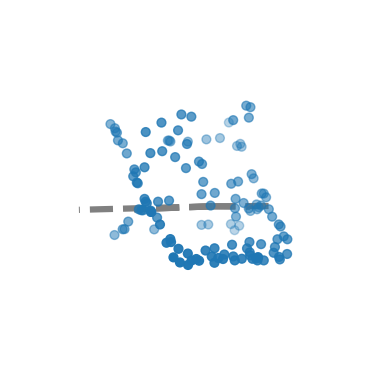

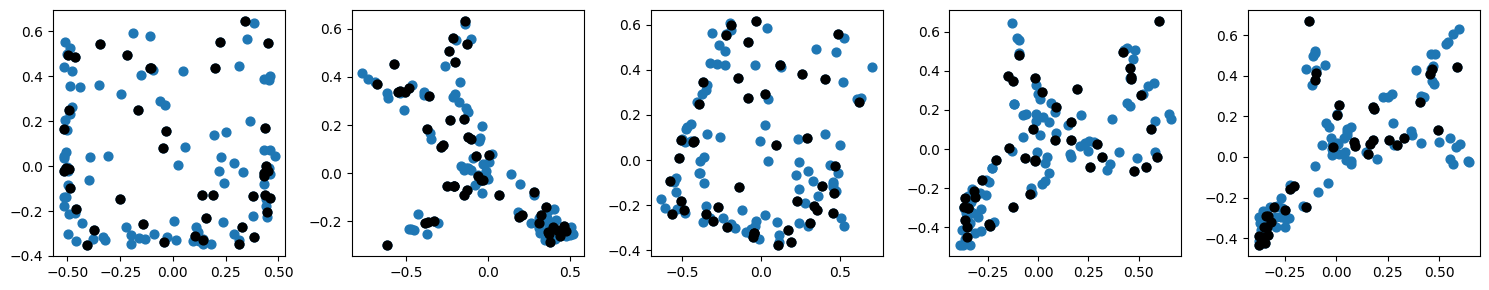

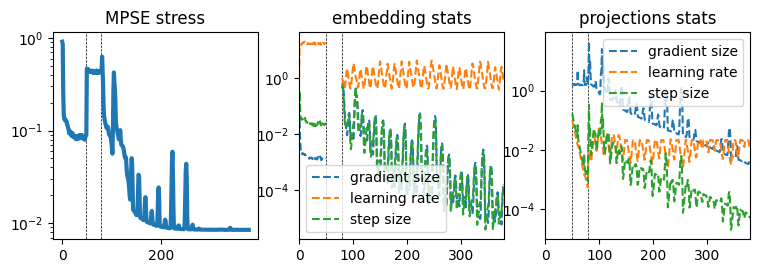

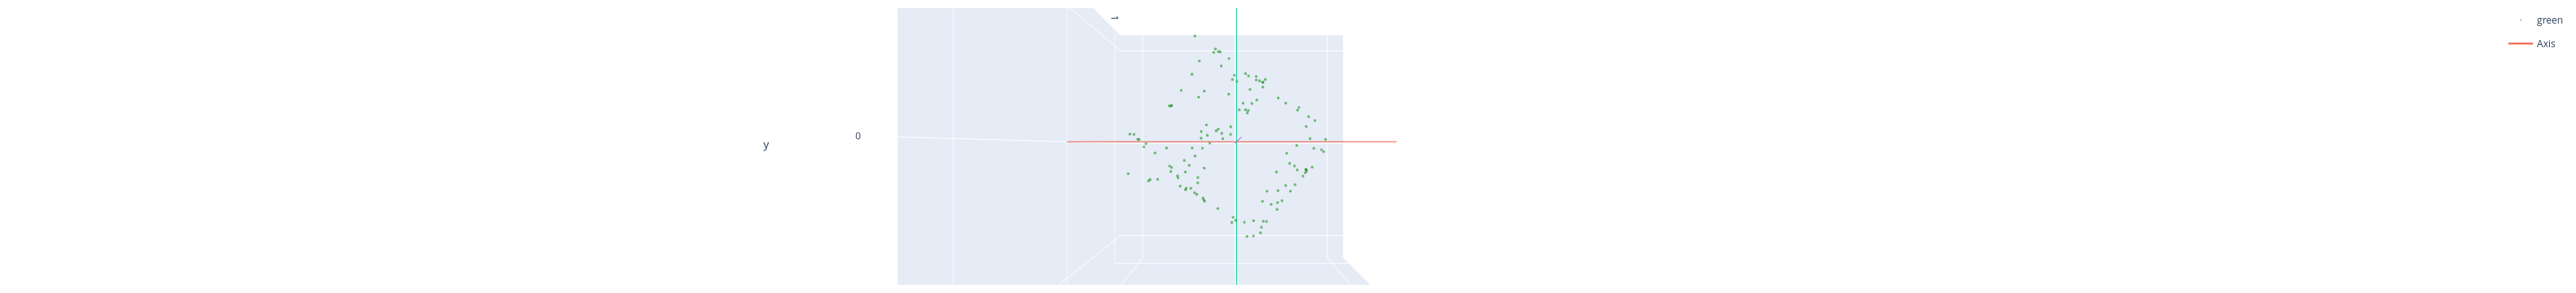

In [7]:
mv = mview.basic(
    dist_mats.copy(), #
    batch_size = 2048,
    max_iter=300, min_grad=1e-4, min_cost=1e-4,
    verbose=2, 
    smart_initialization=True,
    weights=weights_mats.copy(),
    initial_projections = 'cylinder',

    # For fixed projections
    # fixed_projections = projection_mats,

    # For variable projections
    fixed_projections = None,
)

emb_plot = mv.plot_embedding()
imgs_plot = mv.plot_images()
comp_plot = mv.plot_computations()

plt.show()

embeddings = mv.X.copy()
plot_3D([embeddings]).show()

# Distribution of distances between points

The following histogram plot helps to demonstrate the distance distribution of each pair of points

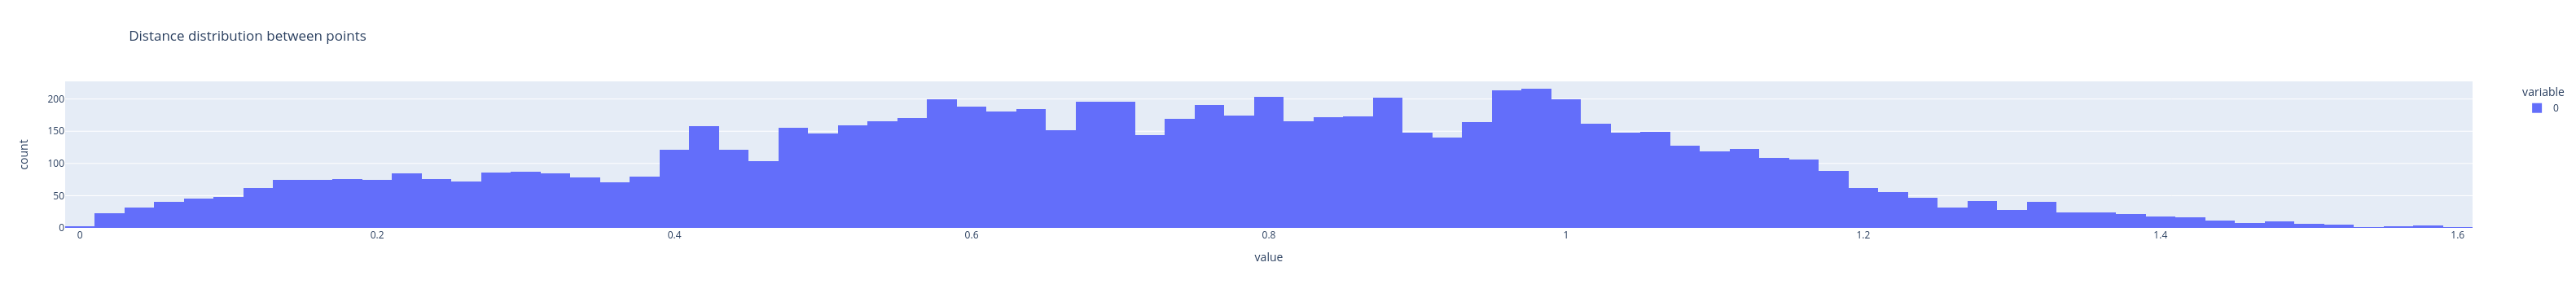

In [8]:
val = np.unique(np.triu(distance_matrix(embeddings, embeddings)))
val.sort()

px.histogram(val, title="Distance distribution between points")

# Metrics

We show the accuracy of the reconstruction with 3 metrics: 

1. RMSE Optimized Alignment (ROA)
1. Earth's Mover Distance (EMD)
1. Chamfer Distance

We also draw both alignment in the same plot to show the alignment quality. Here green points are from ground truth point cloud and red points are from embedded point cloud of output of our algorithm

## With ROA alignment and Loss

2022-11-10 13:37:49.365806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:37:49.370673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:37:49.370893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:37:49.371458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Chamfer Distance: 3.233602109256829
Loss: 0.018342332103442577
EMD: 1.8342332103442578


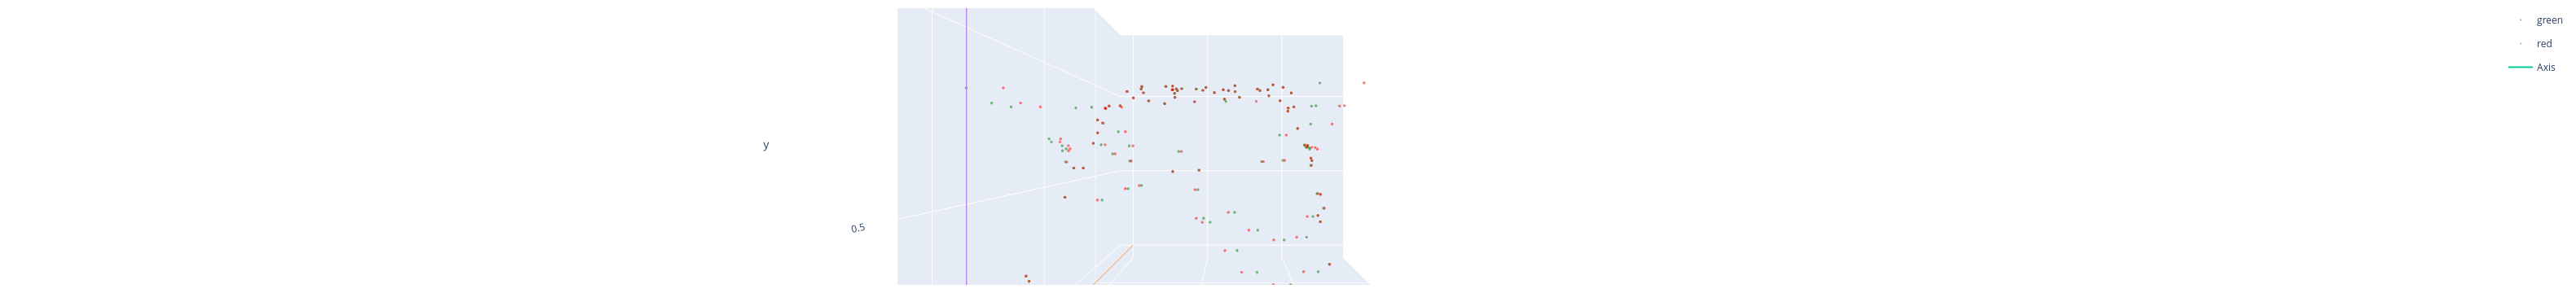

In [9]:
trans_mat, loss = get_optimal_trans_mat(embeddings, points, iterations=1600)
champ_dist = chamfer_distance_numpy(np.expand_dims(apply_transformation(embeddings, trans_mat), axis=0), np.expand_dims(points, axis=0))
print('Chamfer Distance:', champ_dist)
print('Loss:', loss)
print('EMD:', emd(apply_transformation(embeddings, trans_mat), points))
plot_3D([apply_transformation(embeddings, trans_mat), points], colors=['green', 'red'])

# With 4 sample point alignment + ICP

4 Point Alignment: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 15865.98it/s]

0.00027647705235987177
Chamfer Distance: 0.05529541047197435
EMD: 0.027647705235987176


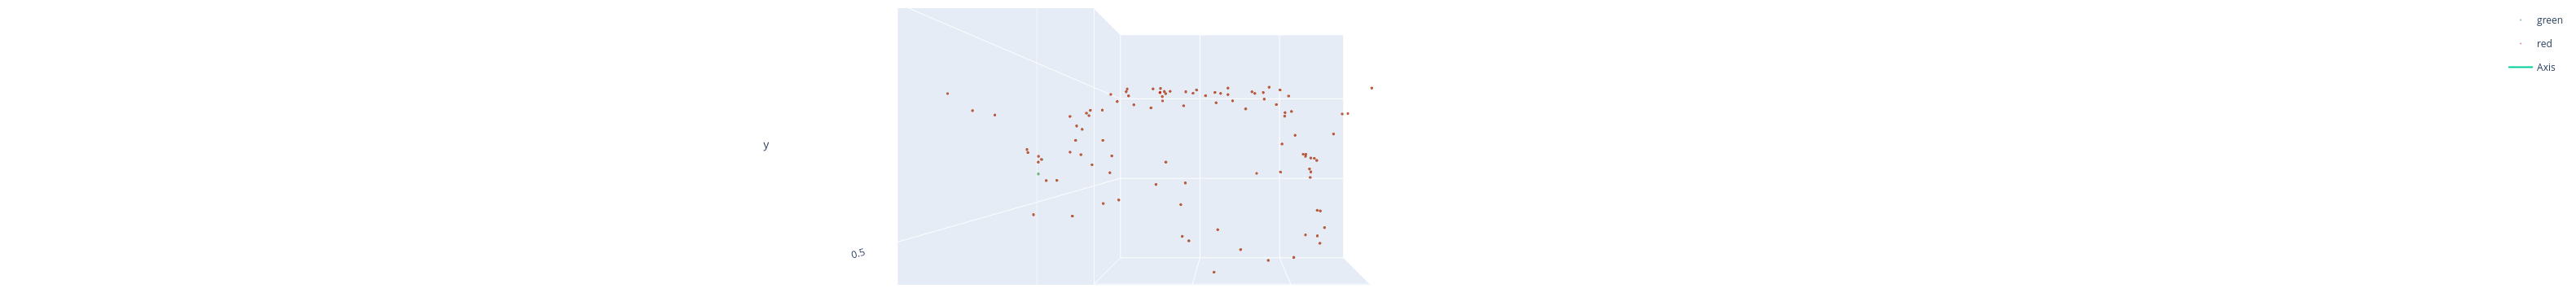

In [10]:
trans_mat, loss = get_4pointsample_transform_mat(embeddings, points)
print(loss)
champ_dist = chamfer_distance_numpy(np.expand_dims(apply_transformation(embeddings, trans_mat), axis=0), np.expand_dims(points, axis=0))
print('Chamfer Distance:', champ_dist)
print('EMD:', emd(apply_transformation(embeddings, trans_mat), points))
plot_3D([apply_transformation(embeddings, trans_mat), points], colors=['green', 'red'])

# With Singular Value Decomposition method of alignment

Loss 0.24553290124648552
Chamfer Distance: 30.69455927525839
EMD: 23.31578349608604


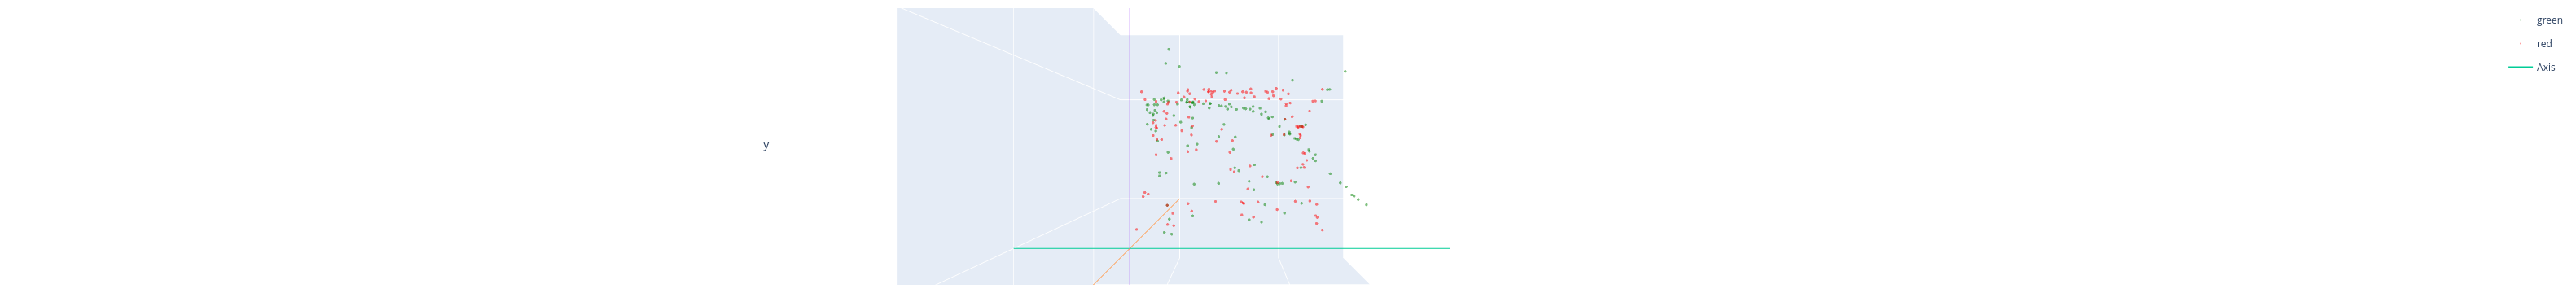

In [11]:
trans_mat, loss = get_svd_trans(embeddings, points)
print('Loss', loss)
champ_dist = chamfer_distance_numpy(np.expand_dims(apply_transformation(embeddings, trans_mat), axis=0), np.expand_dims(points, axis=0))
print('Chamfer Distance:', champ_dist)
print('EMD:', emd(apply_transformation(embeddings, trans_mat), points))
plot_3D([apply_transformation(embeddings, trans_mat), points], colors=['green', 'red'])